**TUGAS MACHINE LEARNING MENGGUNAKAN MODEL RNN**

library pandas, numpy, matplotlib, nltk, dan TensorFlow digunakan untuk memfasilitasi seluruh proses klasifikasi teks.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


membaca file dataset, kolom label v1 dan kolom pesan teks v2,

In [21]:
df = pd.read_csv('/content/spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
spam = df[df['label'] == 'spam'].head(100)
ham = df[df['label'] == 'ham'].head(100)
df = pd.concat([spam, ham]).sample(frac=1, random_state=42).reset_index(drop=True)


membersihkan pesan teks dengan cara mengubah semua huruf menjadi huruf kecil, menghapus tautan, angka, dan tanda baca.

In [22]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text

df['clean_text'] = df['text'].apply(preprocess_text)

Teks yang telah dibersihkan diubah menjadi urutan angka menggunakan tokenizer

In [23]:
# Tokenisasi dan padding
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
max_length = max(len(seq) for seq in sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding='post')

Label teks ('spam' dan 'ham') diubah menjadi angka (1 untuk spam, 0 untuk ham). Setelah itu, data dibagi menjadi data latih dan data uji dengan rasio 80:20 untuk mengevaluasi performa model secara adil.

In [24]:
# Label encoding dan split
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
X = padded
y = df['label_num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model dibuat menggunakan arsitektur Sequential dari Keras, yang terdiri dari lapisan embedding untuk representasi kata, LSTM untuk memahami urutan teks, dropout untuk menghindari overfitting, dan lapisan dense dengan aktivasi sigmoid untuk menghasilkan output biner.



In [25]:
# Model LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

melatih data menggunakan data latih selama 10 epoch. Selama proses pelatihan, model belajar membedakan antara pesan spam dan ham berdasarkan pola kata dalam teks. Akurasi dan loss juga dipantau pada data validasi.

In [26]:
# Training
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.4991 - loss: 0.6945 - val_accuracy: 0.5500 - val_loss: 0.6921
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4008 - loss: 0.6966 - val_accuracy: 0.4500 - val_loss: 0.6955
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5181 - loss: 0.6954 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5327 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4948 - loss: 0.6951 - val_accuracy: 0.4500 - val_loss: 0.6965
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4271 - loss: 0.6967 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5146 - loss: 0.6918 - val_accuracy: 0.4500 - val_loss: 0.6957
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5789 - loss: 0.6900 - val_accuracy: 0.4500 - v

hasil evaluasi model

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
              precision    recall  f1-score   support

         ham       0.45      1.00      0.62        18
        spam       0.00      0.00      0.00        22

    accuracy                           0.45        40
   macro avg       0.23      0.50      0.31        40
weighted avg       0.20      0.45      0.28        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


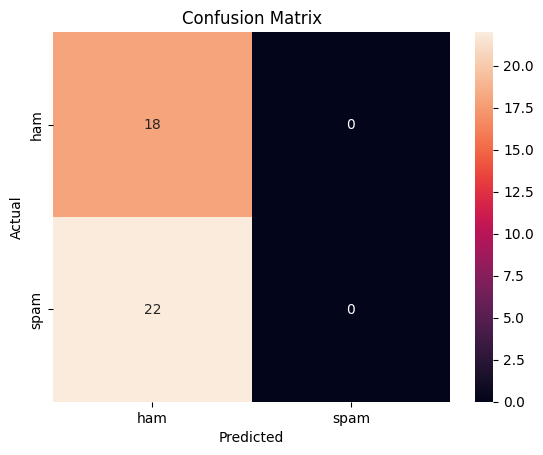

In [27]:
# Evaluasi
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()